# 10 Step Phase Shifting Technique

In [2]:
import os

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

from functions import mask_circ_img, load_raw_img, rad_to_deg

### Load the 10 images

In [3]:
base_path = "ten-step-images-2/"
file_type = ".CR2"

file_names = os.listdir(base_path)

imgs = []

for file_name in file_names:
    imgs.append(load_raw_img(base_path + file_name)[:,:,1] / 10)

In [4]:
alphas = rad_to_deg(np.array([
    np.pi / 2, 
    5*np.pi/8, 
    3*np.pi/4, 
    7*np.pi/8, 
    np.pi/2, 
    np.pi/2, 
    np.pi/2, 
    np.pi/2, 
    np.pi/2, 
    np.pi/2
]))

betas = rad_to_deg(np.array([
    0,
    np.pi/8,
    np.pi/4,
    3*np.pi/8,
    np.pi/2,
    0,
    0,
    np.pi/4,
    0,
    np.pi/2
]))

for i in range(len(alphas)):
    print(f'Alpha: {alphas[i]}, Beta: {betas[i]}')

Alpha: 90.0, Beta: 0.0
Alpha: 112.5, Beta: 22.5
Alpha: 135.0, Beta: 45.0
Alpha: 157.5, Beta: 67.5
Alpha: 90.0, Beta: 90.0
Alpha: 90.0, Beta: 0.0
Alpha: 90.0, Beta: 0.0
Alpha: 90.0, Beta: 45.0
Alpha: 90.0, Beta: 0.0
Alpha: 90.0, Beta: 90.0


Define center and radius for masking

In [5]:
center = (3050, 1880)
radius = 1470

### Calculate the isoclinic parameter
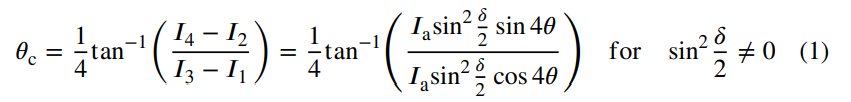

In [6]:
def generate_isoclinic_param(
        img_1: np.ndarray, 
        img_2: np.ndarray, 
        img_3: np.ndarray, 
        img_4: np.ndarray
) -> np.ndarray:
    """
    Images should be in order defined by Ramesh et al. 
    Returns the isoclinic parameter
    """
    return 1/4 * np.arctan2((img_4 - img_2),(img_3 - img_1))

In [7]:
isoclinic_param = generate_isoclinic_param(imgs[0], imgs[1], imgs[2], imgs[3])

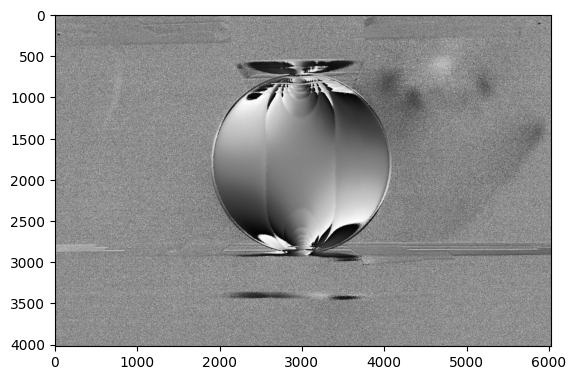

In [8]:
plt.imshow(isoclinic_param, cmap='gray')

In [9]:
plt.imsave('isoclinic.jpg', isoclinic_param, cmap='gray')   

### Generate isochromatic parameter
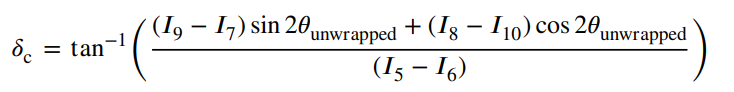


In [10]:
def generate_isochromatic_param(
    img_5: np.ndarray,
    img_6: np.ndarray,
    img_7: np.ndarray,
    img_8: np.ndarray,
    img_9: np.ndarray,
    img_10: np.ndarray,
    isoclinic_param: np.ndarray
) -> np.ndarray:
    return np.arctan(((img_9 - img_7)*np.sin(2*isoclinic_param) + 
                      (img_8 - img_10)*np.cos(2*isoclinic_param))/(img_5 - img_6))

In [11]:
isochromatic_param_rad = np.nan_to_num(generate_isochromatic_param(
    imgs[4],
    imgs[5],
    imgs[6],
    imgs[7],
    imgs[8],
    imgs[9],
    isoclinic_param
))

C:\Users\fredd\AppData\Local\Temp\ipykernel_46972\3016659149.py:10: RuntimeWarning: divide by zero encountered in divide
  return np.arctan(((img_9 - img_7)*np.sin(2*isoclinic_param) +
C:\Users\fredd\AppData\Local\Temp\ipykernel_46972\3016659149.py:10: RuntimeWarning: invalid value encountered in divide
  return np.arctan(((img_9 - img_7)*np.sin(2*isoclinic_param) +


Translate `isochromatic_param` values from `(-pi/2, pi/2)` to `(0, 255)`

In [12]:
isochromatic_param = (isochromatic_param_rad + np.pi/2)*255/(np.pi)

In [13]:
# plt.imsave('isochromatic.jpg', isochromatic_param, cmap='gray')

## Isochromatic Image Processing

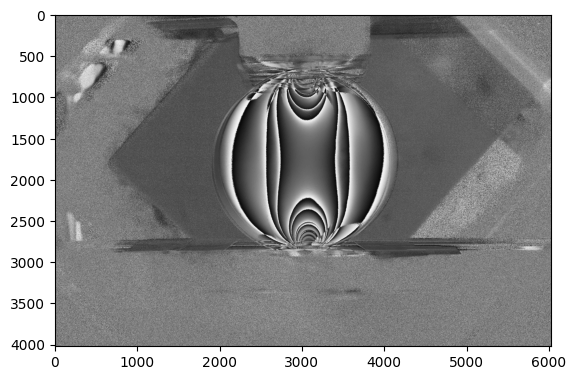

In [14]:
plt.imshow(isochromatic_param, cmap='gray')

In [15]:
# Mask
# img_masked = mask_circ_img(isochromatic_param, (3030, 1770), 1050)
# plt.imshow(img_masked, cmap='gray')

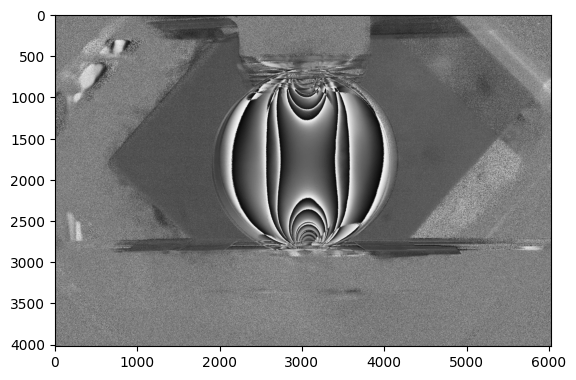

In [35]:
img = isochromatic_param.astype(np.uint8)
plt.imshow(img, cmap='gray')

In [40]:
img_bilat = cv.medianBlur(img, 15)
plt.imsave('blurred.jpg', img_bilat, cmap='gray')

c:\Python310\lib\site-packages\matplotlib\cbook\__init__.py:701: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.array(x, subok=True, copy=copy)


TypeError: Image data of dtype object cannot be converted to float

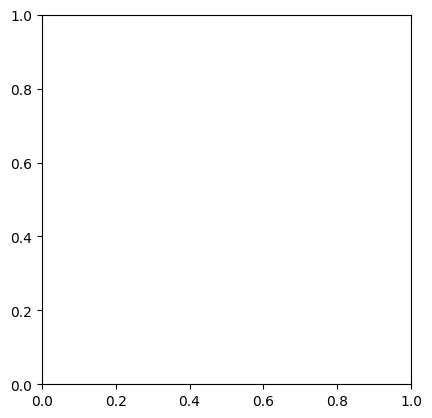

In [34]:
img_thresh = cv.threshold(img, 50.0, 0, 1)
plt.imshow(img_thresh, cmap='gray')